## Discussion

What differences were significant and which were not?

Why do you think that is? What questions remain?

# Your Turn

Can we fine-tune a model to automatically score essays for writing quality?
  * Automatic essays scoring (AES) systems are important components of educational assessment

Can a fine-tuned model be extended to essays outside of the data on which the model was developed?
  * Can we generalize the model?

## Data

The PERSUADE 2.0 corpus

* Comprises over 25,000 persuasive essays (both independent and dependent essays)
* Annotated for
  * discourse elements (e.g., position, claims, and evidence)
  * hierarchical relationships between these elements
  * **holistic score**
* Student information available for
  * grade
  * gender
  * race/ethnicity
  * ELL status
  * economic disadvantage

Our purposes

* You will develop a model of essay quality for the 13,121 independent essays.
  * persuade_2.0_indy_only.csv
  * Predict holistic_essay_score
  * Use a training and test set
  * Save the model


* Apply the model to the 576 essays in the 2019 writing data
  * writing_data_w_meta_data.csv
  * Predict Holistic score





In [3]:
!pip install transformers datasets pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" a

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📦 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import torch
from datasets import Dataset

📄 2. Load and Preprocess PERSUADE 2.0 Data

In [5]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS_5780_spring_25/persuade_2.0_indy_only.csv")
# # Drop NA
df = df.dropna(subset=["full_text", "holistic_essay_score"])

# # Rename columns for Hugging Face
df = df.rename(columns={"full_text": "text", "holistic_essay_score": "label"})
df["label"] = df["label"].astype(float)
# print(df.head)
# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to HF Dataset
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)


🔤 3. Tokenization

In [6]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10496 [00:00<?, ? examples/s]

Map:   0%|          | 0/2625 [00:00<?, ? examples/s]

🧠 4. Load Pretrained Model (Regression)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=1  # regression
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚙️ 5. Training Arguments & Trainer

In [8]:
training_args = TrainingArguments(
    output_dir="./aes_model",
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
)

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.squeeze()
    rmse = np.sqrt(((preds - labels) ** 2).mean())
    mae = mean_absolute_error(labels, preds)
    return {"rmse": rmse, "mae": mae}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-8-b20d0783ea98>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 6. Train and save the Model

In [9]:
trainer.train()
trainer.evaluate()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 844925559 (844925559-vanderbilt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.821100
1000,0.407700
1500,0.329700
2000,0.323200
2500,0.314400
3000,0.266400
3500,0.245500


{'eval_loss': 0.33605509996414185,
 'eval_rmse': 0.579702615737915,
 'eval_mae': 0.45287519693374634,
 'eval_runtime': 19.5265,
 'eval_samples_per_second': 134.433,
 'eval_steps_per_second': 16.849,
 'epoch': 3.0}

In [10]:
model.save_pretrained("aes_model")
tokenizer.save_pretrained("aes_model")

('aes_model/tokenizer_config.json',
 'aes_model/special_tokens_map.json',
 'aes_model/vocab.txt',
 'aes_model/added_tokens.json',
 'aes_model/tokenizer.json')

### 7. Load 2019 Essay Data and Predict

In [11]:
new_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DS_5780_spring_25/writing_data_w_meta_data.csv").dropna(subset=["text"])
new_ds = Dataset.from_pandas(new_df)
new_ds = new_ds.map(tokenize, batched=True)

preds = trainer.predict(new_ds)
new_df["predicted_score"] = preds.predictions.squeeze()

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [12]:
new_df[["text", "predicted_score"]].to_csv("2019_predictions.csv", index=False)

In [13]:
new_df["predicted_score"].describe()

,predicted_score
count,575.000000
mean,3.686564
std,0.879952
min,1.751292
25%,3.069249
50%,3.561555
75%,4.266730
max,5.777707


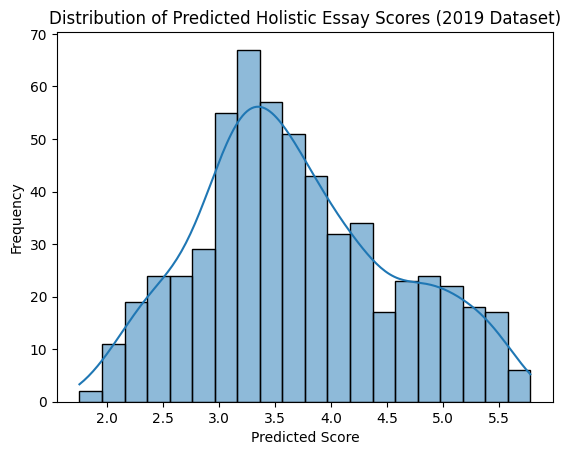

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(new_df["predicted_score"], bins=20, kde=True)
plt.title("Distribution of Predicted Holistic Essay Scores (2019 Dataset)")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = new_df["Holistic"]  # if this column exists
y_pred = new_df["predicted_score"]

print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", mean_squared_error(y_true, y_pred))


MAE: 0.7807802975696067
RMSE: 0.9572567069985108
